## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from dateutil import parser
from datetime import datetime
from sys import getsizeof
import re

import operator
from scipy import stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['axes.axisbelow'] = True

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.express as px
init_notebook_mode(True)

import seaborn as sns

from wand.image import Image as WImage

from hallprobecalib import hpc_ext_path
from hallprobecalib.hpcplots import scatter2d,scatter3d,histo,py_profile

In [4]:
plotdir = hpc_ext_path+'plots/hall_probe_stability/2019-09-04/'

In [5]:
pkl_dir = hpc_ext_path+"datafiles/hall_probe_stability/"
pkl_file_slow = "hall_stability.run04.raw.slow.pkl"
pkl_file_fast = "hall_stability.run04.raw.fast.pkl"
pkl_file_fast_sparse = "hall_stability.run04.sparse.fast.pkl"

In [6]:
df_slow = pd.read_pickle(pkl_dir+pkl_file_slow)

In [7]:
df_fast = pd.read_pickle(pkl_dir+pkl_file_fast)
#df_fast_sparse = pd.read_pickle(pkl_dir+pkl_file_fast_sparse)

In [ ]:
df_fast['seconds_delta'].iloc[60:75]

In [ ]:
df_slow['seconds_delta'].head(10)

In [15]:
def pplot(fig):
    pio.write_image(fig, 'temp.pdf')
    img = WImage(filename='temp.pdf')
    return img

## Cleaning

In [ ]:
directory = "/home/ckampa/Dropbox/LogFiles/"#hpc_ext_path+'datafiles/magnet_stability/nmr/'
filename_slow = '2019-09-04 080031slow.txt' #'2019-08-23 162051slow.txt' # first file stopped Hall probe readings again
filename_fast = '2019-09-04 080000.txt'

In [ ]:
fast_cols_init = ["Date", "Time", 
                  "1", "1_Bx", "1_By", "1_Bz", "1_T",
                  "2", "2_Bx", "2_By", "2_Bz", "2_T",
                  "3", "3_Bx", "3_By", "3_Bz", "3_T",]
                  #"4", "4_Bx", "4_By", "4_Bz", "4_T",
                  #"5", "5_Bx", "5_By", "5_Bz", "5_T",
                  #"6", "6_Bx", "6_By", "6_Bz", "6_T",]

In [ ]:
df_slow = pd.read_csv(directory+filename_slow)

In [ ]:
df_slow

In [ ]:
#df_fast = pd.read_csv(directory+filename_fast, skiprows=7, delim_whitespace=True)#, names=fast_cols_init)

In [ ]:
#len(df_fast.columns)

In [ ]:
# skipping many lines from first attempt which failed
df_fast = pd.read_csv(directory+filename_fast, skiprows=15, delim_whitespace=True, names=fast_cols_init)

In [ ]:
df_fast.head()

In [ ]:
len(df_fast)

In [ ]:
for col in df_fast.columns:
    #print(df_fast[col].dtype)
    if type(df_fast[col].iloc[0]) is np.float64:
        print(f"{col}: mean: {df_fast[col].mean()}")

Looks like maybe probe #3 is in the field

### Cleaning Fast Data Set

In [ ]:
df_fast.head(1)

In [ ]:
df_fast.tail(1)

In [ ]:
df_slow.head(1)

In [ ]:
#df_fast

In [ ]:
'''fast_cols_init = ["Date", "Time", 
                  "1", "1_Bx", "1_By", "1_Bz", "1_T",
                  "2", "2_Bx", "2_By", "2_Bz", "2_T",
                  "3", "3_Bx", "3_By", "3_Bz", "3_T",
                  "4", "4_Bx", "4_By", "4_Bz", "4_T",
                  "5", "5_Bx", "5_By", "5_Bz", "5_T",]''';

In [ ]:
#len(fast_cols_init)

In [ ]:
#len(df_fast.columns)

In [ ]:
# raw values on every other line....
df_fast_cal = df_fast[::2]
df_fast_raw = df_fast[1::2]

In [ ]:
df_fast_cal.reset_index(drop=True, inplace=True)
df_fast_raw.reset_index(drop=True, inplace=True)

In [ ]:
#df_fast_cal

In [ ]:
#df_fast_raw

In [ ]:
#dates = [parser.parse(row.Date+" "+row.Time[:-4]) for row in df_fast_cal.itertuples()]
dates = [datetime.strptime(row.Date+" "+row.Time, "%Y-%m-%d %H:%M:%S:%f") for row in df_fast_cal.itertuples()]

In [ ]:
df_fast_cal["Datetime"] = pd.to_datetime(dates)
df_fast_cal = df_fast_cal.set_index("Datetime")

In [ ]:
#dates = [parser.parse(row.Date+" "+row.Time[:-4]) for row in df_fast_cal.itertuples()]
dates = [datetime.strptime(row.Date[1:]+" "+row.Time, "%Y-%m-%d %H:%M:%S:%f") for row in df_fast_raw.itertuples()]

In [ ]:
df_fast_raw["Datetime"] = pd.to_datetime(dates)
df_fast_raw = df_fast_raw.set_index("Datetime")

In [ ]:
df_fast_raw.drop(columns=["Date","Time"], inplace=True)

In [ ]:
df_fast_cal.drop(columns=["Date","Time"], inplace=True)

In [ ]:
raw_col_dict = {i: "Raw_"+i for i in df_fast_raw.columns}
cal_col_dict = {i: "Cal_"+i for i in df_fast_cal.columns}

In [ ]:
df_fast_cal.rename(columns=cal_col_dict, inplace=True)
df_fast_raw.rename(columns=raw_col_dict, inplace=True)

In [ ]:
df_fast = pd.concat([df_fast_cal, df_fast_raw], axis=1)

In [ ]:
len(df_fast)

### Slow Control Data Cleaning

In [ ]:
dates = [parser.parse(row.Time) for row in df_slow.itertuples()]# if isdatetime(row.Time.values[0])]

In [ ]:
df_slow["Datetime"] = pd.to_datetime(dates)#.astype("str")
df_slow = df_slow.set_index("Datetime")

There is no Hall probe data.

In [ ]:
df_fast = df_fast.loc[:df_slow.index[-1]]

In [ ]:
df_fast.tail(1)

In [ ]:
## THIS STEP TAKES A LONG TIME
df_fast.loc[:,"NMR"] = [df_slow.iloc[df_slow.index.get_loc(row, method='nearest')][" NMR [T]"] for row in df_fast.index]

In [ ]:
for i in range(1,4):
    df_fast.eval(f"Cal_{i}_Bmag = (Cal_{i}_Bx**2+Cal_{i}_By**2+Cal_{i}_Bz**2)**(1/2)", inplace=True)
    df_fast.eval(f"Cal_{i}_Res = (NMR - Cal_{i}_Bmag)", inplace=True)
    df_fast.eval(f"Cal_{i}_Res_Rel = (NMR - Cal_{i}_Bmag) / NMR", inplace=True)

for i in range(1,4):
    for B in ["Bx","By","Bz"]:
        #df_fast.eval(f"Cal_{i}_Bmag = (Cal_{i}_Bx**2+Cal_{i}_By**2+Cal_{i}_Bz**2)**(1/2)", inplace=True)
        df_fast.eval(f"Cal_{i}_{B}_Res = (NMR - Cal_{i}_{B})", inplace=True)
        df_fast.eval(f"Cal_{i}_{B}_Res_Rel = (NMR - Cal_{i}_{B}) / NMR", inplace=True)


t0 = pd.to_timedelta(df_fast.index.values)[0] / pd.offsets.Second(1)

df_fast["seconds_delta"] = pd.to_timedelta(df_fast.index.values) / pd.offsets.Second(1) - t0#1565697533.416
df_slow["seconds_delta"] = pd.to_timedelta(df_slow.index.values) / pd.offsets.Second(1) - t0#1565697533.416

In [ ]:
for i in range(1,4):
    df_fast[f"Cal_{i}_Transverse"] = (df_fast[f"Cal_{i}_Bx"]**2+df_fast[f"Cal_{i}_By"]**2)**(1/2)
    df_fast[f"Cal_{i}_Theta"] = np.arccos(df_fast[f"Cal_{i}_Bz"]/df_fast[f"Cal_{i}_Bmag"])
    df_fast[f"Cal_{i}_Phi"] = np.arccos(df_fast[f"Cal_{i}_Bx"]/df_fast[f"Cal_{i}_Transverse"])

In [ ]:
df_slow.to_pickle(pkl_dir+pkl_file_slow)

In [ ]:
df_fast.to_pickle(pkl_dir+pkl_file_fast)

In [ ]:
#col_drop = [i for i in df_fast.columns if ("1" not in i) and ("NMR" not in i)]
col_drop = [i for i in df_fast.columns if ("3" not in i) and ("NMR" not in i)]

In [ ]:
#col_drop

In [ ]:
df_fast_sparse = df_fast.drop(columns=col_drop)

In [ ]:
df_fast_sparse.to_pickle(pkl_dir+pkl_file_fast_sparse)

In [ ]:
getsizeof(df_slow) / 1000/1000, getsizeof(df_fast) / 1000/1000, getsizeof(df_fast_sparse) / 1000/1000

## Plotting

### First Attempt

In [8]:
len(df_slow)

13498

In [9]:
len(df_fast)

1214260

In [10]:
df_fast = df_fast.loc["2019-09-04 08:45:00":"2019-09-13 12:57:00"]

In [11]:
df_slow = df_slow.loc["2019-09-04 08:45:00":"2019-09-13 12:57:00"]

In [12]:
len(df_slow)

8808

In [13]:
len(df_fast)

792347

In [ ]:
df_fast.columns

In [ ]:
cols = df_fast.columns

In [ ]:
print([c for c in cols if "Cal_1" in c])

In [16]:
fig = scatter2d(df_slow.index, df_slow[" NMR [T]"], show_plot=False);

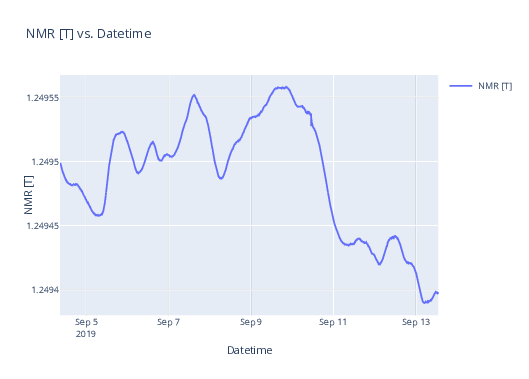

In [17]:
pplot(fig)

In [18]:
fig = scatter2d(df_fast[100:500].index, df_fast[100:500]["Cal_3_Bmag"], show_plot=False)

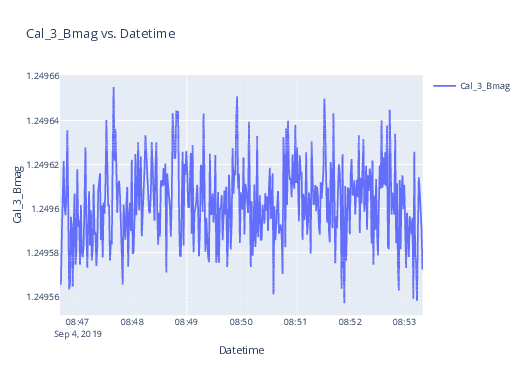

In [19]:
pplot(fig)

In [ ]:
fig2 = scatter2d(df_slim.index, random)

In [ ]:
histo(df_slim.Cal_3_Bmag, bins=50)

In [ ]:
fig.add_traces([fig2.data[0]])

In [ ]:
df_slim = df_fast[100:500]

In [ ]:
df_slim["Cal_3_Bmag"].describe()

In [ ]:
std = df_slim["Cal_3_Bmag"].std()
mean = df_slim["Cal_3_Bmag"].mean()

In [ ]:
random = np.random.normal(loc=mean, scale=std, size=400)

In [ ]:
random = pd.Series(random)

In [ ]:
random.name = "random"

In [ ]:
histo(random, bins=50)

In [ ]:
fig = scatter2d(df_slow.index, df_slow[" Chamber Wall CH13"])

In [ ]:
filename = plotdir+"NMR_vs_time"
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
fig = scatter2d(df_fast[::10].index, df_fast[::10]["Cal_3_Bmag"], show_plot=False);
fig.layout.title = "|B_Hall]| [T] vs. Datetime";
fig.layout.yaxis.title = "|B_Hall]| [T]";

In [ ]:
filename = plotdir+"Hall_vs_time"
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
P = 3
N = 60#10#30#10#20#10#30#60
df_fast.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
df_fast.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_fast["NMR"] - df_fast[f"Cal_{P}_Bmag_Avg"])/df_fast["NMR"]

In [ ]:
df_fast_5 = df_fast[N // 2::N]

In [ ]:
fig = scatter2d(df_fast_5.index, df_fast_5["Cal_3_Bmag_Avg"], markers=True, lines=False, size_list=3, show_plot=False);
fig.layout.title = "|B_Hall]| [T] vs. Datetime<br> 60 s Average";
fig.layout.yaxis.title = "|B_Hall]| [T]";
filename = plotdir+"Hall_vs_time_avg_60s"
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
fig = py_profile(df_fast.seconds_delta, df_fast["Cal_3_Bmag"], x_bins=len(df_fast) // 1000, show_plot=True)

In [ ]:
fig = scatter2d(df_fast.index, df_fast["Cal_3_Bmag"], show_plot=False);
fig.layout.title = "|B_Hall]| [T] vs. Datetime<br> 15 s Average";
fig.layout.yaxis.title = "|B_Hall]| [T]";
filename = plotdir+"Hall_vs_time_avg_15s"
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
fig = scatter2d(df_slow.seconds_delta, df_slow[" NMR [T]"])

In [ ]:
fighall = scatter2d(df_fast[::100].seconds_delta, df_fast[::100]["Cal_3_Bmag"])

In [ ]:
figprof = py_profile(df_fast.seconds_delta, df_fast["Cal_3_Bmag"], 
                     xrange=[100000, 600000],
                     x_bins=5000, show_plot=True)

In [ ]:
figprof = py_profile(df_fast.seconds_delta, df_fast["Cal_3_Bmag"], x_bins=200, show_plot=True)

In [ ]:
fig.add_traces([fighall.data[0],figprof.data[0]])

In [ ]:
fig.layout.title = "Scatter, Profile: NMR and |B_hall| Comparison";
fig.layout.yaxis.title = "|B| [T]";
fig.layout.xaxis.title = "$\Delta t\ \\text{[s]}$";
filename = plotdir+"nmr_hall_comparison"
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
#P = 3
#N = 1000#10#30#10#20#10#30#60
#df_fast.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
#df_fast.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_fast["NMR"] - df_fast[f"Cal_{P}_Bmag_Avg"])/df_fast["NMR"]

In [ ]:
#df_fast_5 = df_fast[N // 2::N]

In [ ]:
#1000 / 60 /60 

In [ ]:
#figavg = scatter2d(df_fast_5.seconds_delta, df_fast_5["Cal_3_Bmag_Avg"], markers=True, lines=False, size_list=[5])

In [ ]:
#figavg.add_traces([figprof.data[0]])

In [ ]:
fig.add_traces([figprof.data[0]])

In [ ]:
P = 3
N = 60#10#30#10#20#10#30#60
df_fast.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
df_fast.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_fast["NMR"] - df_fast[f"Cal_{P}_Bmag_Avg"])/df_fast["NMR"]

In [ ]:
df_fast_5 = df_fast[N // 2::N]

In [ ]:
fig = scatter2d(df_fast_5["NMR"], df_fast_5["Cal_3_Bmag_Avg"], lines=False, markers=True)

In [ ]:
fig.layout.title = "|B_hall| (avg.) vs. NMR <br> 60 s Average";
fig.layout.yaxis.title = "|B_Hall| [T]";
fig.layout.xaxis.title = "NMR [T]";
filename = plotdir+"nmr_hall_correlation"
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
df_fast.eval('Raw_3_Bmag = (Raw_3_Bx**2 + Raw_3_By**2 + Raw_3_Bz**2)**(1/2)',inplace=True)

In [ ]:
fig = histo(df_fast["Raw_3_Bmag"], bins=50)

In [ ]:
df_slow.columns

In [ ]:
temps_ch = [a for a in df_slow.columns if ("CH" in a) and int(a[-2:])<21]# or "HVAC" in a]
temps_ch.append(" Hall Element")
temps_ch.append(" Floor")
temps_ch.append(" Roof")
temps_ch.append(" Yoke")
temps_ch.append("Yoke (center magnet)")

In [ ]:
temps_ch

In [ ]:
df_slow[temps_ch].describe()

In [ ]:
df_slow[temps_ch].plot(kind="box")

In [ ]:
#fig = px.box(df_slow[temps_ch],)# x=temps_ch,
             #notched=True, # used notched shape
             #title="Box plot of total bill",
             #hover_data=["day"] # add day column to hover data
            #)
#fig.show()

In [ ]:
fig = scatter2d([df_slow.index for c in temps_ch],[df_slow[c] for c in temps_ch],inline=True, show_plot=False);
fig.layout.title = "Temp vs. Datetime"
fig.layout.yaxis.title = "Temp [deg. C]"

In [ ]:
fig.show()

In [ ]:
#fname = 'temps_scatter'
fname = 'temps_scatter_full'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')
plot(fig, filename=plotdir+fname+'.html', auto_open=False)

In [ ]:
# correlation
fig = scatter2d(df_slow["Yoke (center magnet)"], df_slow[" NMR [T]"], lines=False, markers=True,)

In [ ]:
fname = 'nmr_vs_yoke_correlation'
pio.write_image(fig, plotdir+fname+'.pdf')
pio.write_image(fig, plotdir+fname+'.png')

In [ ]:
fig = scatter2d(df_fast.iloc[299:902].seconds_delta, df_fast.iloc[299:902]["Cal_3_Bmag"], show_plot=False)

In [ ]:
figprof_ = py_profile(df_fast.seconds_delta, df_fast["Cal_3_Bmag"],
                      xrange=[300.11895,900.35695],
                      x_bins=20, show_plot=True)

In [ ]:
figprof = py_profile(df_fast.iloc[300:901].seconds_delta, df_fast.iloc[300:901]["Cal_3_Bmag"],
                     x_bins=20, show_plot=False)

In [ ]:
figprof_.add_traces([figprof.data[0]])

In [ ]:
fig.add_traces([figprof.data[0]])

In [ ]:
15.00595*2

In [ ]:
315.1249-15.00595

In [ ]:
df_fast.iloc[300:901].seconds_delta.describe()

In [ ]:
# bin size
345.1368 - 315.1249

In [ ]:
(end - start) / bins

In [ ]:
start = 300.11895
end = 900.35695

delta_t = end - start

bins = 20
step = (end - start) / bins

average_time = np.zeros(bins)
average_cal = np.zeros(bins)
std_cal = np.zeros(bins)

In [ ]:
for i in range(bins):
    minx = start + i*step
    maxx = minx + step
    midx = minx + step / 2
    cal = df_fast.query(f"(seconds_delta >= {minx}) & (seconds_delta < {maxx})")["Cal_3_Bmag"]
    average_cal[i] = cal.mean()#cal.sum() / step
    std_cal[i] = cal.std()
    average_time[i] = midx

In [ ]:
figavg = scatter2d(average_time, average_cal, lines=False, markers=True, size_list=[4])

In [ ]:
fig.add_traces([figavg.data[0]])

In [ ]:
(30**(1/2))

In [ ]:
figprof, tprof = py_profile(df_fast.seconds_delta, df_fast["Cal_3_Bmag"],
                     xrange=[300,900],
                     x_bins=20, show_plot=False, return_tprof=True)

In [ ]:
fig.add_traces([figprof.data[0]])

In [ ]:
df_nmr = df_slow.query("(seconds_delta > 299) & (seconds_delta < 901)")

In [ ]:
fignmr = scatter2d(df_nmr.seconds_delta, df_nmr[" NMR [T]"], show_plot=False)

In [ ]:
fig.add_traces([fignmr.data[0]])

In [ ]:
tprof

In [ ]:
tprof.GetBinEntries(0)

In [ ]:
# test speed

In [ ]:
%timeit figprof = py_profile(df_fast.seconds_delta, df_fast["Cal_3_Bmag"],xrange=[300,900],x_bins=20, show_plot=False)

In [ ]:
def pythonic_profile(x, y, x_bins, xrange=None, show_plot=True):
    if xrange == None:
        xrange = [x.min(), x.max()]
    start = xrange[0]
    end = xrange[1]

    delta_t = end - start

    bins = x_bins
    step = (end - start) / bins

    average_time = np.zeros(bins)
    average_cal = np.zeros(bins)
    std_cal = np.zeros(bins)

    for i in range(bins):
        minx = start + i*step
        maxx = minx + step
        midx = minx + step / 2
        print(minx, midx, maxx)
        #cal = x.query(f"(seconds_delta >= {minx}) & (seconds_delta < {maxx})")#["Cal_3_Bmag"]
        xmask = (x >= minx) & (x <= maxx)
        cal = y[xmask]
        print(i, len(cal))
        average_cal[i] = cal.mean()#cal.sum() / step
        std_cal[i] = cal.std() / len(cal)
        average_time[i] = midx

    fig = scatter2d(average_time, average_cal, lines=False, markers=True, size_list=[4], show_plot=False)
    figavg.update_traces(error_y = dict(type="data", array=std_cal, visible=True))
    figavg.update_traces(error_x = dict(type="constant", value=step/2, visible=True))
    
    return fig

In [ ]:
figprof = pythonic_profile(df_fast.seconds_delta, df_fast["Cal_3_Bmag"], x_bins=20, 
                           xrange=[300,900], show_plot=True)

In [ ]:
df_fast.Cal_3_Bmag.describe()

In [ ]:
figprof = py_profile(df_fast.seconds_delta, df_fast["Cal_3_Bmag"],
                     xrange=[300,900],
                     x_bins=20, show_plot=True)

In [ ]:
start = 300
end = 900

delta_t = end - start

bins = 20
step = (end - start) / bins

average_time = np.zeros(bins)
average_cal = np.zeros(bins)
std_cal = np.zeros(bins)

In [ ]:
for i in range(bins):
    minx = start + i*step
    maxx = minx + step
    midx = minx + step / 2
    cal = df_fast.query(f"(seconds_delta >= {minx}) & (seconds_delta < {maxx})")["Cal_3_Bmag"]
    average_cal[i] = cal.mean()#cal.sum() / step
    std_cal[i] = cal.std() / np.sqrt(len(cal))
    average_time[i] = midx

In [ ]:
figavg = scatter2d(average_time, average_cal, lines=False, markers=True, size_list=[4])

In [ ]:
#figavg.update_traces(error_y = dict(type="data", array=std_cal, visible=True))
#figavg.update_traces(error_x = dict(type="constant", value=step/2, visible=True))

In [ ]:
figprof.add_traces([figavg.data[0]])

In [ ]:
P = 3
N = 30#60#10#30#10#20#10#30#60
df_fast.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
df_fast.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_fast["NMR"] - df_fast[f"Cal_{P}_Bmag_Avg"])/df_fast["NMR"]

df_fast_5 = df_fast[N // 2::N]

In [ ]:
figavgr = scatter2d(df_fast[300:901].seconds_delta, df_fast[300:901].Cal_3_Bmag_Avg, lines=False, markers=True, size_list=[4])

In [ ]:
figprof.add_traces([figavgr.data[0]])

In [ ]:
figavgr2 = scatter2d(df_fast_5[10:30].seconds_delta, df_fast_5[10:30].Cal_3_Bmag_Avg, lines=False, markers=True, size_list=[4])

In [ ]:
figprof.add_traces([figavgr2.data[0]])

In [ ]:
avg_cal3 = [15+(i* 30) for i in range(20)]

In [ ]:
df_avg = df[]

In [ ]:
figavg = 

In [ ]:
fig.layout.yaxis.title = "|Hall| [T]"

In [ ]:
iplot(fig)

In [ ]:
fig = scatter2d(df_fast[::10].index, df_fast[::10]["Cal_3_Bmag"])

In [ ]:
fig = scatter2d(df_fast[::100].NMR, df_fast[::100].Cal_3_Bmag, lines=False, markers=True)

In [ ]:
#for cal in ["1", "2", "3", "4", "5"]:
#    fig = scatter2d(df_fast.index, df_fast[f"Cal_{cal}_Bmag"])

Probe #4 is in the magnet.

In [ ]:
P = 3
N = 10#30#10#20#10#30#60
df_fast.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
df_fast.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_fast["NMR"] - df_fast[f"Cal_{P}_Bmag_Avg"])/df_fast["NMR"]

In [ ]:
df_fast_5 = df_fast[N // 2::N]

In [ ]:
#df_fast_5.loc[:, "Cal_Mag_Avg"] = [df_fast.iloc[i- for i in range(len(df_fast_5))]

In [ ]:
### 60 second

In [ ]:
fig = px.scatter_matrix(df_fast[::100], dimensions=["NMR","Cal_1_Bmag","Cal_2_Bmag","Cal_3_Bmag",])
fig.show()

In [ ]:
len(df_fast)

In [ ]:
#perc = 0.001
#bad_map = (df_fast[f"Cal_{P}_Bmag"] < df_fast[f"Cal_{P}_Bmag"].quantile(perc)) | (df_fast[f"Cal_{P}_Bmag"] > df_fast[f"Cal_{P}_Bmag"].quantile(1-perc))
#df_fast[bad_map]

In [ ]:
#df_fast2 = df_fast[~bad_map]

In [ ]:
#df_fast2.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast2[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
#df_fast2.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_fast2["NMR"] - df_fast2[f"Cal_{P}_Bmag_Avg"])/df_fast2["NMR"]

In [ ]:
#df_fast2_5 = df_fast2[N // 2::N]

In [ ]:
#fig = px.scatter_matrix(df_fast2, dimensions=["NMR","Cal_1_Bmag","Cal_2_Bmag","Cal_3_Bmag","Cal_4_Bmag","Cal_5_Bmag",])
#fig.show()

In [ ]:
#plot(fig)

In [ ]:
#fig = scatter2d(df_fast2.NMR, df_fast2[f"Cal_{P}_Bmag"], lines=False, markers=True)

In [ ]:
from scipy import stats

In [ ]:
primary_corr = dict()
for col in df_slow.columns:
    if (df_slow[col].dtype == np.float64):
        slope_v, intercept_v, r_value_v, p_value_v, std_err_v = stats.linregress(df_slow[col], df_slow[" NMR [T]"])
        #print(col,r_value_v,p_value_v,std_err_v)
        primary_corr[col] = r_value_v

sorted_primary_corr = sorted(primary_corr.items(), key=operator.itemgetter(1))

sorted_primary_corr

In [ ]:
primary_corr = dict()
for col in df_fast.columns:
    if (df_fast[col].dtype == np.float64) & ("T" not in col): #& ("Cal_4" in col):
        slope_v, intercept_v, r_value_v, p_value_v, std_err_v = stats.linregress(df_fast[col], df_fast["NMR"])
        #print(col,r_value_v,p_value_v,std_err_v)
        primary_corr[col] = r_value_v

sorted_primary_corr = sorted(primary_corr.items(), key=operator.itemgetter(1))

sorted_primary_corr

In [ ]:
df_fast["Cal_3_Bmag_Avg_Res_Rel"].describe()

In [ ]:
df_fast["NMR"].describe()

In [ ]:
len(df_fast)

In [ ]:
df_fast[f"Cal_{P}_Res_Rel"].describe()

In [ ]:
fig = histo(df_fast[f"Cal_{P}_Res"], bins=100, yscale='linear', cut=[0.,0.999])

In [ ]:
fig = histo(df_fast[f"Cal_{P}_Res_Rel"], bins=100, yscale='linear', cut=[0.,0.999])

In [ ]:
df_fast[df_fast[f"Cal_{P}_Res_Rel"] == df_fast[f"Cal_{P}_Res_Rel"].max()]

In [ ]:
fig = histo(df_fast[f"Cal_{P}_Res_Rel"], bins=100, yscale='linear', cut=[0.,0.999], show_plot=False)

In [ ]:
fig.layout.xaxis.title = "(NMR [T] - |Hall| [T]) / (NMR [T])"
fig.layout.title = "Histo: Relative Residuals"

In [ ]:
filename = plotdir+"rel_residuals"
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
fig = histo(df_fast[f"Cal_{P}_Bmag_Avg_Res_Rel"], bins=100, yscale='linear', cut=[0.,0.999], show_plot=True)

In [ ]:
fig = scatter2d([df_fast.index,df_fast.index,df_fast_5.index], [df_fast.Cal_1_Bmag,df_fast.Cal_1_Bmag_Avg,df_fast_5.Cal_1_Bmag_Avg], inline=True)

In [ ]:
fig = histo(df_fast2[f'Cal_{P}_Bmag'], bins=50, inline=True)
fig = histo(df_fast2[f'Cal_{P}_Bmag_Avg'], bins=50, inline=True)
fig = histo(df_fast2_5[f'Cal_{P}_Bmag_Avg'], bins=50, inline=True)

In [ ]:
df_slow[" NMR [T]"].hist(bins=50)

In [ ]:
df_fast.eval("Cal_Res = (NMR - Cal_1_Bmag)", inplace=True)
df_fast.eval("Cal_Res_Rel = (NMR - Cal_1_Bmag) / NMR", inplace=True)

In [ ]:
fig = histo(df_fast2.Cal_4_Res_Rel, bins=50, inline=True)
fig = histo(df_fast2.Cal_4_Bmag_Avg_Res_Rel, bins=50, inline=True)
fig = histo(df_fast2_5.Cal_4_Bmag_Avg_Res_Rel, bins=50, inline=True)
#fig = histo(df_fast.Cal_1_Bmag_Avg_Res_Rel, bins=50, inline=True)

In [ ]:
fig = histo(df_slow[" NMR [T]"], bins=10, inline=True)

In [ ]:
df_slow[" NMR [T]"].plot()

In [ ]:
fig = scatter2d(df_slow.index, df_slow[" NMR [T]"], inline=True)

In [ ]:
fig = scatter2d(df_fast2.index, df_fast2[f"Cal_{P}_Bmag"], inline=True)

In [ ]:
import copy

In [ ]:
# Seeing effect of number of points in average
#N = 10#30#10#20#10#30#60
P = 3
Ns = [1,5,10,30,60, 120,]# 240, 480, 960, 1930,1930*2, 1930*4, 1930*8]#[5, 10, 30, 60]

df_fast_N = []

for N in Ns:
    df_fast.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
    df_fast.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_fast["NMR"] - df_fast[f"Cal_{P}_Bmag_Avg"])/df_fast["NMR"]
    df_fast_N.append(copy.copy(df_fast[N // 2::N]))
    #print(df_fast_N[-1]["Cal_1_Bmag_Avg_Res_Rel"].describe())

#df_fast_5 = df_fast[N // 2::N]
#print([df[f"Cal_{P}_Bmag_Avg_Res_Rel"].describe() for df in df_fast_N])
[df[f"Cal_{P}_Bmag_Avg_Res_Rel"].describe() for df in df_fast_N]

In [ ]:
df_fast_N[0][f"Cal_{P}_Bmag_Avg_Res_Rel"].describe()

In [ ]:
fig = scatter2d([df_fast2.index, df_fast_N[-2].index, df_slow.index], [df_fast2.Cal_4_Bmag,df_fast_N[-2].Cal_4_Bmag_Avg, df_slow[" NMR [T]"]], inline=True)

In [ ]:
fig = histo([df_fast.Cal_Res_Rel]+[df.Cal_1_Bmag_Avg_Res_Rel for df in df_fast_N], bins=50,same_bins=True, show_plot=False, opacity=0.5, inline=True)
fig.update_traces(histnorm='probability density')
iplot(fig)

In [ ]:
 NMR [T]fig = histo([df_fast.Cal_Res_Rel]+[df.Cal_1_Bmag_Avg_Res_Rel for df in [df_fast_N[0]]], bins=50,same_bins=False, show_plot=False, opacity=0.5, inline=True)
fig.update_traces(histnorm='probability density')
iplot(fig)

In [ ]:
fig = histo([df.Cal_1_Bmag_Avg_Res_Rel for df in [df_fast_N[0]]], bins=50,same_bins=False, show_plot=True, opacity=0.5, inline=True)

In [ ]:
df_fast_N[0]["Cal_1_Bmag_Avg_Res_Rel"].describe()

In [ ]:
getsizeof(df_fast_N[0]) / 1000 / 1000

### Noise on all Hall probes

In [ ]:
#df_fast.columns

In [ ]:
'''for i in range(1,6):
    df_fast.eval(f"Cal_{i}_Bmag = (Cal_{i}_Bx**2+Cal_{i}_By**2+Cal_{i}_Bz**2)**(1/2)", inplace=True)
    df_fast.eval(f"Cal_{i}_Res = (NMR - Cal_{i}_Bmag)", inplace=True)
    df_fast.eval(f"Cal_{i}_Res_Rel = (NMR - Cal_{i}_Bmag) / NMR", inplace=True)

for i in range(1,6):
    for B in ["Bx","By","Bz"]:
        #df_fast.eval(f"Cal_{i}_Bmag = (Cal_{i}_Bx**2+Cal_{i}_By**2+Cal_{i}_Bz**2)**(1/2)", inplace=True)
        df_fast.eval(f"Cal_{i}_{B}_Res = (NMR - Cal_{i}_{B})", inplace=True)
        df_fast.eval(f"Cal_{i}_{B}_Res_Rel = (NMR - Cal_{i}_{B}) / NMR", inplace=True)

df_fast["seconds_delta"] = pd.to_timedelta(df_fast.index.values) / pd.offsets.Second(1) - 1565697533.416

df_slow["seconds_delta"] = pd.to_timedelta(df_slow.index.values) / pd.offsets.Second(1) - 1565697533.416''';

In [ ]:
#pd.to_timedelta(df_slow.index.values) / pd.offsets.Second(1)

In [ ]:
getsizeof(df_fast) / 1000 / 1000

In [ ]:
# relative residual

In [ ]:
for i in range(1,6):
    for B in ["Bx", "By", "Bz"]:
        fig = histo(df_fast[f"Cal_{i}_{B}_Res_Rel"], bins=50, show_plot=False, inline=True)
        filename = f"histo_Cal_{i}_{B}_Res_Rel"
        pio.write_image(fig, plotdir+f"relative_residuals/components/{filename}.pdf")
        pio.write_image(fig, plotdir+f"relative_residuals/components/{filename}.png")

In [ ]:
for i in range(1,6):
    fig = histo(df_fast[f"Cal_{i}_Res_Rel"], bins=50, show_plot=False, inline=True)
    filename = f"histo_Cal_{i}_Res_Rel"
    pio.write_image(fig, plotdir+f"relative_residuals/magnitude/{filename}.pdf")
    pio.write_image(fig, plotdir+f"relative_residuals/magnitude/{filename}.png")

In [ ]:
# residual

In [ ]:
for i in range(1,6):
    for B in ["Bx", "By", "Bz"]:
        fig = histo(df_fast[f"Cal_{i}_{B}_Res"], bins=50, show_plot=False, inline=True)
        filename = f"histo_Cal_{i}_{B}_Res"
        pio.write_image(fig, plotdir+f"residuals/components/{filename}.pdf")
        pio.write_image(fig, plotdir+f"residuals/components/{filename}.png")

In [ ]:
for i in range(1,6):
    fig = histo(df_fast[f"Cal_{i}_Res"], bins=50, show_plot=False, inline=True)
    filename = f"histo_Cal_{i}_Res"
    pio.write_image(fig, plotdir+f"residuals/magnitude/{filename}.pdf")
    pio.write_image(fig, plotdir+f"residuals/magnitude/{filename}.png")

In [ ]:
Ns = [5,10,30,60, 120, 240, 480, 960, 1930,1930*2, 1930*4, 1930*8]#[5, 10, 30, 60]

df_fast_N = []

for N in Ns:
    df_fast.loc[:, "Cal_1_Bmag_Avg"] = df_fast["Cal_1_Bmag"].rolling(window = N, center=True).mean()
    df_fast.loc[:, "Cal_1_Bmag_Avg_Res_Rel"] = (df_fast["NMR"] - df_fast["Cal_1_Bmag_Avg"])/df_fast["NMR"]
    df_fast_N.append(copy.copy(df_fast[N // 2::N]))


### Check Field Angle and Average
- Leaving for historical purposes, but column names have changed

In [ ]:
'''df_fast["Cal_1_Transverse"] = (df_fast["Cal_1_Bx"]**2+df_fast["Cal_1_By"]**2)**(1/2)
df_fast["theta"] = np.arccos(df_fast["Cal_1_Bz"]/df_fast["Cal_1_Bmag"])
df_fast["phi"] = np.arccos(df_fast["Cal_1_Bx"]/df_fast["Cal_1_Transverse"])''';

In [ ]:
fig = histo(df_fast.theta*180/np.pi, bins=50, inline=True)
fig = histo(df_fast.phi*180/np.pi, bins=50, inline=True)

In [ ]:
# Seeing effect of number of points in average
#N = 10#30#10#20#10#30#60
Ns = [5,10,30,60, 120, 240, ]#480, 960, 1930,1930*2, 1930*4, 1930*8]#[5, 10, 30, 60]

df_fast_N = []

for N in Ns:
    df_fast.loc[:, "theta_Avg"] = df_fast["theta"].rolling(window = N, center=True).mean()
    df_fast.loc[:, "phi_Avg"] = df_fast["phi"].rolling(window = N, center=True).mean()
    df_fast_N.append(copy.copy(df_fast[N // 2::N]))
    #print(df_fast_N[-1]["Cal_1_Bmag_Avg_Res_Rel"].describe())

#df_fast_5 = df_fast[N // 2::N]
#print([df["Cal_1_Bmag_Avg_Res_Rel"].describe() for df in df_fast_N])

In [ ]:
fig = histo([df_fast.theta]+[df.theta_Avg for df in df_fast_N], bins=50,same_bins=True, show_plot=False, opacity=0.5, inline=True)
fig.update_traces(histnorm='probability density')
iplot(fig)

In [ ]:
fig = scatter2d(df_fast.index, df_fast.theta, inline=True)

In [ ]:
fig = scatter2d(df_fast.index, df_fast.phi, inline=True)

In [ ]:
df_fast_N[0].theta_Avg.plot()

In [ ]:
fig = scatter2d([df_fast.index, df_fast_N[2].index, df_slow.index], [df_fast.Cal_1_Bmag,df_fast_N[2].Cal_1_Bmag_Avg, df_slow[" NMR [T]"]], inline=True)

### Plots for Email

In [ ]:
len(df_fast)

Last time: 66240

In [ ]:
795048 / 60 / 60 /24

In [ ]:
66240 / 60 / 60

In [ ]:
# get probe name dictionary
directory = "/home/ckampa/Dropbox/LogFiles/"
filename_fast = '2019-09-04 080000.txt'

with open(directory+filename_fast, 'r') as file:
    lines = file.readlines()[6:9]

In [ ]:
lines

In [ ]:
id_reg = re.compile(": (.+?)  Offset")

In [ ]:
hall_ids_list = [id_reg.findall(line)[0] for line in lines]

In [ ]:
hall_ids_list

In [ ]:
hall_ids = {i+1: hall for i,hall in enumerate(hall_ids_list)}

In [ ]:
hall_ids

In [ ]:
N = 3

In [ ]:
len(df_fast)

In [ ]:
fig = scatter2d(df_fast[::100].index, df_fast[::100][f"Raw_{N}_Bx"], inline=True)

In [ ]:
fig = scatter2d(df_fast.index, df_fast[f"Raw_{N}_Bz"], inline=True)

In [ ]:
fig = scatter2d(df_fast.index, df_fast[f"Cal_{N}_Bz"], inline=True)

In [ ]:
fig = scatter2d(5*[df_fast.index], [df_fast[f'Cal_{i}_T'] for i in range(1,4)])

In [ ]:
fig = scatter2d([df_fast.seconds_delta, df_slow.seconds_delta], [df_fast[f'Cal_1_T'], df_slow[" Hall Element"]],show_plot=False)

In [ ]:
figprof = py_profile(df_fast.seconds_delta, df_fast.Cal_1_T, x_bins=50, show_plot=False)

In [ ]:
figprof2 = py_profile(df_slow.seconds_delta, df_slow[" Hall Element"], x_bins=50,xrange=[df_fast.seconds_delta.min(),df_fast.seconds_delta.max()], show_plot=False)

In [ ]:
fig.add_traces([figprof.data[0],figprof2.data[0]])

In [ ]:
df_fast.loc[:,"HallElement"] = [df_slow.iloc[df_slow.index.get_loc(row, method='nearest')][" Hall Element"] for row in df_fast.index]

In [ ]:
#fig = scatter2d(df_fast.HallElement, df_fast.Cal_1_T, markers=True, lines=False)

In [ ]:
fig = py_profile(df_fast.HallElement, df_fast.Cal_1_T, x_bins=12)

In [ ]:
df_fast["Cal_4_Bmag"].describe()

In [ ]:
fig = scatter2d(df_fast.index, df_fast["Cal_1_Bmag"], inline=True)

In [ ]:
fig = scatter2d(df_slow_old.index, df_slow_old[" NMR [T]"], inline=True)

In [ ]:
fig = scatter2d(df_slow.index, df_slow[" NMR [T]"], inline=True)

In [ ]:
start = 0
end = 600
x_bins = 20

In [ ]:
fig = scatter2d(df_fast.seconds_delta[start:end], df_fast.Cal_1_Bmag[start:end],show_plot=False)

In [ ]:
figprof = py_profile(df_fast.seconds_delta[start:end], df_fast.Cal_1_Bmag[start:end], x_bins = x_bins, show_plot=False)

In [ ]:
fig.add_trace(figprof.data[0])

In [ ]:
#fig.update_traces(visible=False)

In [ ]:
pio.write_image(fig, plotdir+"scatter_plus_profile_test.pdf")

In [ ]:
start = 1000
end = 1600
x_bins = 20

comp_old = "Mag"
comp_new = "Bmag"

In [ ]:
# old data
fig = scatter2d(df_slow_old.seconds_delta[start:end], df_slow_old[f"Cal_{comp_old}"][start:end],show_plot=False)
figprof = py_profile(df_slow_old.seconds_delta[start:end], df_slow_old[f"Cal_{comp_old}"][start:end], x_bins = x_bins, show_plot=False)
fig.add_trace(figprof.data[0])

In [ ]:
for i in range(1,6):
    fig = scatter2d(df_fast.seconds_delta[start:end], df_fast[f'Cal_{i}_{comp_new}'][start:end],show_plot=False)
    figprof = py_profile(df_fast.seconds_delta[start:end], df_fast[f'Cal_{i}_{comp_new}'][start:end], x_bins = x_bins, show_plot=False)
    fig.add_trace(figprof.data[0])
    iplot(fig)

In [ ]:
start = 1000
end = 1120
x_bins = 6

In [ ]:
# old data
fig = scatter2d(df_slow_old.seconds_delta[start:end], df_slow_old[f"Cal_{comp_old}"][start:end],show_plot=False)
figprof = py_profile(df_slow_old.seconds_delta[start:end], df_slow_old[f"Cal_{comp_old}"][start:end], x_bins = x_bins, show_plot=False)
fig.add_trace(figprof.data[0])

In [ ]:
for i in range(1,6):
    fig = scatter2d(df_fast.seconds_delta[start:end], df_fast[f'Cal_{i}_{comp_new}'][start:end],show_plot=False)
    figprof = py_profile(df_fast.seconds_delta[start:end], df_fast[f'Cal_{i}_{comp_new}'][start:end], x_bins = x_bins, show_plot=False)
    fig.add_trace(figprof.data[0])
    iplot(fig)

In [ ]:
fig = histo(df_fast.Cal_1_Res_Rel, bins=50, show_plot=False)
fig.layout.xaxis.title = ("(NMR - |B_hall|) / NMR")
iplot(fig)

In [ ]:
df_slow_old["Cal_Res_Rel"] = (df_slow_old[" NMR [T]"] - df_slow_old["Cal"]) / df_slow_old[" NMR [T]"]

In [ ]:
df_slow_old = df_slow_old.loc["2019-08-10 12:30:00":]

In [ ]:
fig = histo(df_slow_old.Cal_Mag_Res_Rel, bins=50, show_plot=False)
fig.layout.xaxis.title = ("(NMR - |B_hall|) / NMR")
iplot(fig)

In [ ]:
df_slow_old.columns

In [ ]:
## AVERAGING

In [ ]:
df_fast["day"] = df_fast.index.day

In [20]:
import copy

Average of residuals

In [22]:
# Seeing effect of number of points in average
#N = 10#30#10#20#10#30#60
P = 3
Ns = [10,60,120, 300, 1000]#[5, 10, 30, 60]

df_fast_N = []

for N in Ns:
    #df_fast.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
    df_fast.loc[:, f"Cal_{P}_Res_Rel_Avg"] = df_fast[f"Cal_{P}_Res_Rel"].rolling(window = N, center=True).mean()
    df_fast_N.append(copy.copy(df_fast[N // 2::N]))
    #print(df_fast_N[-1]["Cal_1_Bmag_Avg_Res_Rel"].describe())

#df_fast_5 = df_fast[N // 2::N]
#print([df["Cal_1_Bmag_Avg_Res_Rel"].describe() for df in df_fast_N])

In [24]:
fig = histo([df_fast[f'Cal_{P}_Res_Rel']]+[df[f'Cal_{P}_Res_Rel_Avg'] for df in df_fast_N], bins=100,
            same_bins=False, show_plot=False, opacity=0.5, inline=True, cut=[0.,0.999])
fig.update_traces(histnorm='probability') # "probability density"
fig.layout.xaxis.title = ("(NMR - |B_hall|) / NMR")
fig.layout.yaxis.title = ("Normalized Counts")
#iplot(fig)

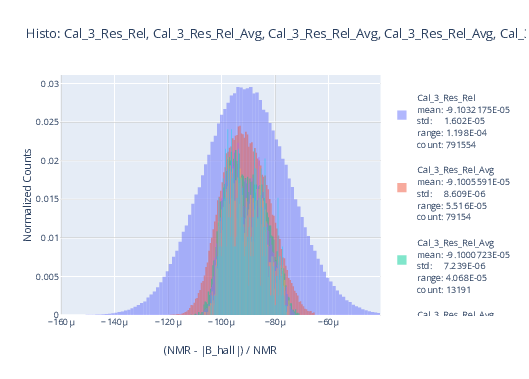

In [25]:
pplot(fig)

Residuals of average

In [26]:
# Seeing effect of number of points in average
#N = 10#30#10#20#10#30#60
P = 3
Ns = [10,60,120, 300, 1000]#[5, 10, 30, 60]

df_fast_N = []

for N in Ns:
    df_fast.loc[:, f"Cal_{P}_Bmag_Avg"] = df_fast[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
    df_fast.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_fast["NMR"] - df_fast[f"Cal_{P}_Bmag_Avg"])/df_fast["NMR"]
    df_fast_N.append(copy.copy(df_fast[N // 2::N]))
    #print(df_fast_N[-1]["Cal_1_Bmag_Avg_Res_Rel"].describe())

#df_fast_5 = df_fast[N // 2::N]
#print([df["Cal_1_Bmag_Avg_Res_Rel"].describe() for df in df_fast_N])

In [27]:
fig = histo([df_fast[f'Cal_{P}_Res_Rel']]+[df[f'Cal_{P}_Bmag_Avg_Res_Rel'] for df in df_fast_N], bins=100,
            same_bins=False, show_plot=False, opacity=0.5, inline=True, cut=[0.,0.999])
fig.update_traces(histnorm='probability') # "probability density"
fig.layout.xaxis.title = ("(NMR - |B_hall|) / NMR")
fig.layout.yaxis.title = ("Normalized Counts")
#iplot(fig)

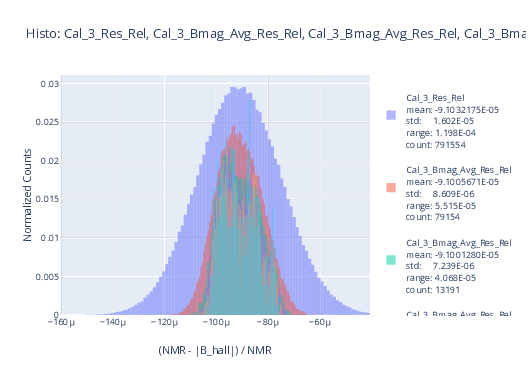

In [28]:
pplot(fig)

In [ ]:
fig.layout.xaxis.title = "(NMR [T] - |Hall| [T]) / (NMR [T])"
fig.layout.title = "Histo: Relative Residuals<br>Averaging: NONE, 10 s, 60 s"

filename = plotdir+"rel_residuals_avg"
pio.write_image(fig, filename+".pdf")
pio.write_image(fig, filename+".png")

In [ ]:
fig = px.histogram(df_fast_N[1], x='Cal_3_Bmag_Avg_Res_Rel', histnorm="probability", color="day")
fig.show()

In [ ]:
fig = px.histogram(df_fast_N[1], x='Cal_3_Bmag_Avg_Res_Rel', histnorm="probability", color="day")
fig.show()

In [ ]:
#df_slim = df_fast.query("day in [5,6,7,8,9,10]")
df_slim = df_fast.query("5 <= day <= 10")

In [ ]:
len(df_slim)

In [ ]:
fig = px.histogram(df_slim, x='Cal_3_Bmag_Avg_Res_Rel', histnorm="probability density", color="day")
fig.show()

In [ ]:
# Seeing effect of number of points in average
#N = 10#30#10#20#10#30#60
P = 3
Ns = [10,60,120, 300, 1000]#[5, 10, 30, 60]

df_fast_N = []

for N in Ns:
    df_slim.loc[:, f"Cal_{P}_Bmag_Avg"] = df_slim[f"Cal_{P}_Bmag"].rolling(window = N, center=True).mean()
    df_slim.loc[:, f"Cal_{P}_Bmag_Avg_Res_Rel"] = (df_slim["NMR"] - df_slim[f"Cal_{P}_Bmag_Avg"])/df_slim["NMR"]
    df_fast_N.append(copy.copy(df_slim[N // 2::N]))
    #print(df_fast_N[-1]["Cal_1_Bmag_Avg_Res_Rel"].describe())

#df_fast_5 = df_fast[N // 2::N]
#print([df["Cal_1_Bmag_Avg_Res_Rel"].describe() for df in df_fast_N])

In [ ]:
fig = histo([df_slim[f'Cal_{P}_Res_Rel']]+[df[f'Cal_{P}_Bmag_Avg_Res_Rel'] for df in df_fast_N], bins=100,
            same_bins=False, show_plot=False, opacity=0.5, inline=True, cut=[0.,0.999])
fig.update_traces(histnorm='probability') # "probability density"
fig.layout.xaxis.title = ("(NMR - |B_hall|) / NMR")
fig.layout.yaxis.title = ("Normalized Counts")
iplot(fig)

In [ ]:
# Seeing effect of number of points in average
#N = 10#30#10#20#10#30#60
Ns = [10,60]#[5, 10, 30, 60]

df_fast_N = []

for N in Ns:
    df_slow_old.loc[:, "Cal_1_Bmag_Avg"] = df_slow_old["Cal_Mag"].rolling(window = N, center=True).mean()
    df_slow_old.loc[:, "Cal_1_Bmag_Avg_Res_Rel"] = (df_slow_old[" NMR [T]"] - df_slow_old["Cal_1_Bmag_Avg"])/df_slow_old[" NMR [T]"]
    df_fast_N.append(copy.copy(df_slow_old[N // 2::N]))
    #print(df_fast_N[-1]["Cal_1_Bmag_Avg_Res_Rel"].describe())

#df_fast_5 = df_fast[N // 2::N]
#print([df["Cal_1_Bmag_Avg_Res_Rel"].describe() for df in df_fast_N])

In [ ]:
fig = histo([df_slow_old.Cal_Mag_Res_Rel]+[df.Cal_1_Bmag_Avg_Res_Rel for df in df_fast_N], bins=15,same_bins=False, show_plot=False, opacity=0.5, inline=True)
fig.update_traces(histnorm='probability density')
fig.layout.xaxis.title = ("(NMR - |B_hall|) / NMR")
fig.layout.yaxis.title = ("Normalized Counts")
iplot(fig)